In [19]:
from sqlalchemy import create_engine, inspect


#Dades de connexió
usuario='root'
contraseña="123"
host='localhost'
puerto=3306
nombre_base_datos='bbdd_tasca_4'

#Crear la URL de la connexió
url_conexion=f"mysql+pymysql://{usuario}:{contraseña}@{host}:{puerto}/{nombre_base_datos}"

try:
    #Crear el engine de SQLAlchemy
    engine=create_engine(url_conexion)
    cnx=engine.connect()

    print("conexió correcta")
    #cnx.close()
except Exception as e:
    print(f"Error al conectar con SQLAlchemy: {e}")

conexió correcta


In [20]:
#Recordar que inspect del codi anterior quan creo la connexió amb sqlalchemy
#from sqlalchemy import create_engine, inspect
#necessitarem pandas per utilizar pd.read_sql
import pandas as pd
from datetime import date, time, datetime

inspector=inspect(engine)
nombre_tablas=inspector.get_table_names()
#df=pd.DataFrame()
#print(df)


def extr_any(data):
    
    any_actual=int(datetime.now().year)  
    #any_naix=int(str(cadena[-4:]))
    any_naix=int(data.year)
    return(any_actual-any_naix)



# Diccionario para almacenar los DataFrames
df= {}

for taula in nombre_tablas:
    query=f"select * from {taula}"
    
    try:
        df[taula] = pd.read_sql(query, cnx)
        print(f"Taula '{taula}' carregada correctamente.")
    except Exception as e:
        print(f"Error al carregar la taula '{taula}':{e}")
        
df["products_ids"]["weight"]=df["products_ids"]["weight"].apply(float)

df["users"]["country"]=df["users"]["country"].astype(str)
df["transactions"]["timestamp"]=pd.to_datetime(df["transactions"]["timestamp"])


df_companies=df["companies"]
df_credit_card=df["credit_card"]
df_products_ids=df["products_ids"]
df_trans_x_product=df["trans_x_product"]
df_transactions=df["transactions"]
df_users=df["users"]

#Per l'exercici 5 necessitem al principi carregar una taula de country de la taula companyies
#amb country de la taula users a la taula transactions. Si no ho carreguem al principio
#ho hauríem de fer amb Power Query
sql_ex_5="""WITH trans_and_companies AS
            (SELECT
                t.id,
                t.user_id,
                t.declined,
                c.country country_comp,
                t.amount
                FROM transactions t
                LEFT JOIN companies c ON c.company_id=t.business_id)
             SELECT
                 t.id id_transac,
                 t.declined,
                 t.country_comp,
                 u.country country_user,
                 t.amount
             FROM trans_and_companies t
             LEFT JOIN users u ON u.id=t.user_id;"""
                       
df_id_trans_country_comp_country_user=pd.read_sql(sql_ex_5,cnx)
print("Taula df_id_trans_country_comp_country_user para exercicio 5 cargada correctamente.")


sql_ex_7="""WITH count_prod_x_trans AS(
        SELECT
            tp.id,
            COUNT(tp.product_ids) count_prod
            FROM trans_x_product tp
            GROUP BY tp.id
            ORDER BY tp.id ASC),
        amount_x_prod AS 
        (SELECT
            t.id,
            t.lat,
            t.longitude,
            t.user_id,
            (t.amount/cp.count_prod) amount_x_prod
        FROM transactions t
        INNER JOIN count_prod_x_trans cp ON cp.id=t.id
        ORDER BY t.id ASC)
        SELECT
            t.id,
            p.price,
            p.weight,
            t.amount_x_prod,
            t.lat,
            t.longitude,
            u.birth_date
        FROM trans_x_product tp
        INNER JOIN products_ids p ON p.id=tp.product_ids
        INNER JOIN amount_x_prod t ON t.id=tp.id
        INNER JOIN users u ON u.id=t.user_id;"""


df_preu_pes_amount_lat_long_x_trans=pd.read_sql(sql_ex_7,cnx)

df_preu_pes_amount_lat_long_x_trans["birth_date"]=pd.to_datetime(df_preu_pes_amount_lat_long_x_trans["birth_date"])

#La funció extr_any definida a la capcelera d'aquí.
df_preu_pes_amount_lat_long_x_trans["edad"]=df_preu_pes_amount_lat_long_x_trans["birth_date"].apply(extr_any)
df_preu_pes_amount_lat_long_x_trans.columns=["id","preu","pes","preu_mig_x_trans","lat","long","any_naix","edat"]
print("Taula df_preu_pes_amount_lat_long_x_trans para exercicio 7 cargada correctamente.")


#Preparació taula pel violint de l'Exercici 1 del Nivell 3
df_trans_merge_company=df["transactions"].merge(df["companies"],how="inner",left_on="business_id",right_on="company_id")

son_paisos_top_5=df_trans_merge_company["country"].isin(["Germany","United Kingdom","Sweeden","Ireland","Norway","Canada"])
df_trans_merge_company_top_5=df_trans_merge_company[son_paisos_top_5]
df_trans_merge_company_top_5_merge_users=df_trans_merge_company_top_5.merge(df["users"],how="inner",left_on="user_id",right_on="id")
print("Taula df_trans_merge_company_top_5 para exercicio 1 Nivell 3 cargada correctamente.")


#Preparacioó taula pel FaceGrid de l'Exercici 2 del Nivell 3
df_trans_merge_company_top_5_user=df_trans_merge_company_top_5.merge(df["users"], how="left", left_on="user_id",right_on="id")
df_trans_merge_company_top_5_user["birth_date"]=pd.to_datetime(df_trans_merge_company_top_5_user["birth_date"],format="%b %d, %Y")
def extr_edad(data):
    
    any_actual=int(datetime.now().year)  
    #any_naix=int(str(cadena[-4:]))
    any_naix=int(data.year)
    return(any_actual-any_naix)

df_trans_merge_company_top_5_user["edat"]=df_trans_merge_company_top_5_user["birth_date"].apply(extr_edad)
def rg_edad(edat):
    
    if edat in range(20,35):
        return "20 a 34 anys"
    
    
    elif edat in range(35,46):
        return "35 a 45 anys"
    else:
        return "resto"
    
#Creem una columna nova per categoritzar l'edat en dos rangs 
df_trans_merge_company_top_5_user["rg_edat"]=df_trans_merge_company_top_5_user["edat"].apply(rg_edad)
print("Taula df_trans_merge_company_top_5_user para exercicio 1 Nivell 3 cargada correctamente.")




#He provat de fer aquesta query i veig que funciona bé. Es per veure que puc provar
#de fer querys si no em funcionés els merges o groupby en python. L'únic que la conexió
#no podria estar tancada i per tant és farragós obrir i tancar conexions.

# query="""SELECT
# c.company_name,
# SUM(t.amount)
# FROM transactions t
# INNER JOIN companies c ON t.business_id=c.company_id
# GROUP BY c.company_name; """

# df_companies=pd.read_sql(query, cnx)


# Cerrar la conexión
cnx.close()


Taula 'companies' carregada correctamente.
Taula 'credit_card' carregada correctamente.
Taula 'num_trans_and_decl_x_companies' carregada correctamente.
Taula 'products_ids' carregada correctamente.
Taula 'trans_x_product' carregada correctamente.
Taula 'transactions' carregada correctamente.
Taula 'users' carregada correctamente.
Taula df_id_trans_country_comp_country_user para exercicio 5 cargada correctamente.
Taula df_preu_pes_amount_lat_long_x_trans para exercicio 7 cargada correctamente.
Taula df_trans_merge_company_top_5 para exercicio 1 Nivell 3 cargada correctamente.
Taula df_trans_merge_company_top_5_user para exercicio 1 Nivell 3 cargada correctamente.


In [21]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           587 non-null    object        
 1   card_id      587 non-null    object        
 2   business_id  587 non-null    object        
 3   timestamp    587 non-null    datetime64[ns]
 4   amount       587 non-null    float64       
 5   declined     587 non-null    int64         
 6   product_ids  587 non-null    object        
 7   user_id      587 non-null    int64         
 8   lat          587 non-null    float64       
 9   longitude    587 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 46.0+ KB


El power BI no permet treballar amb taules anidades, i un diccionari ho seria, així que cada df per separat

#### **Exercici 1**

##### Representar una variable numèrica.
 

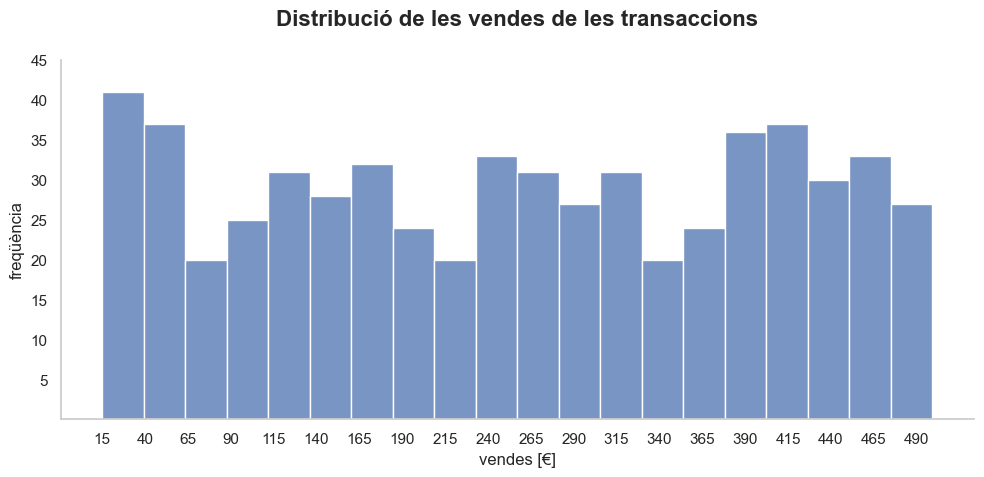

In [22]:
#sns.displot retorna una variable de FaceGrid, un objecte de seaborns 
#type(plot)
#seaborn.axisgrid.FacetGrid
import matplotlib.pyplot as plt
import seaborn as sns

#Dintre dels objectes per gràficar phython qualsevol variable, s'anomena dataset. 
#O sigui aquesta línea dataset=df["transactions"] ho fa ell internament amb les
#variables que li passes al objecte graficador de python.
dataset=df["transactions"]

#Amb height i aspect puc controlar l'amplada del gràfic
plot=sns.displot(dataset["amount"],bins=20,height=5, aspect=2)
plot.set_axis_labels('vendes [€]', 'freqüència')

#ax sí es de tipus Matplotlib
#type(plot.ax)
#matplotlib.axes._axes.Axes

#El objecte plot té atributs d'objectes ax i figure que són objectes de matplotlib.
#Així puc retocar tots els detalls amb matplolib
ax=plot.ax
fig=plot.figure

ax.set_title('Distribució de les vendes de les transaccions',fontsize=16,pad=25,fontweight='bold')
fig.subplots_adjust(top=0.85)

#Primer grafico el gràfic, i després veig que aquestes serien les millors 
#etiques per l'eix x
min_amount=int(min(df["transactions"]["amount"]))
max_amount=int(max(df["transactions"]["amount"]))

#Per tal que coincideix els valors de l'eix amb les barres faig aquest bucle
list_x=[i for i in range(15,500,25)]
#En aquest cas vull que l'ultim element de l'eix yu sigui 45
list_y=[i for i in range(5,50,5)]

#Aquests mètodes modifiquens els valors de l'eix amb les llistes que jo he fet
ax.set_xticks(list_x)
ax.set_yticks(list_y)
# Treure les quadrícules del fons
ax.grid(False)
#plt.figure(10,4)
plt.show()


#### **Exercici 2**

##### Dues variables numèriques

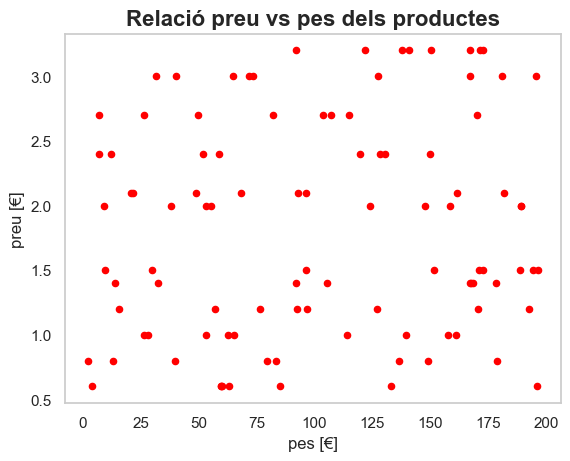

In [23]:
import matplotlib.pyplot as plt

#Per simular l'objecte Py de Power BI, a partir d'aquí assignem dataset al DataFrame que conté les variables que passem al visualitzador Py
dataset=df_products_ids


ax=dataset.plot.scatter(x="price",y="weight", color="red")

ax.set_title("Relació preu vs pes dels productes",fontsize=16,fontweight='bold')
ax.set_xlabel("pes [€]")
ax.set_ylabel("preu [€]")
# Treure les quadrícules del fons
ax.grid(False)
plt.show()

#### **Exercici 3**

##### Una variable categòrica

In [24]:
dataset=pd.DataFrame(df["users"]["country"])

type(dataset.value_counts())

pd.Series

#type(dataset)

pandas.core.series.Series

In [25]:
type(dataset["country"].value_counts())


pandas.core.series.Series

Text(0.5, 1.0, "Nombre d'usuaris per país")

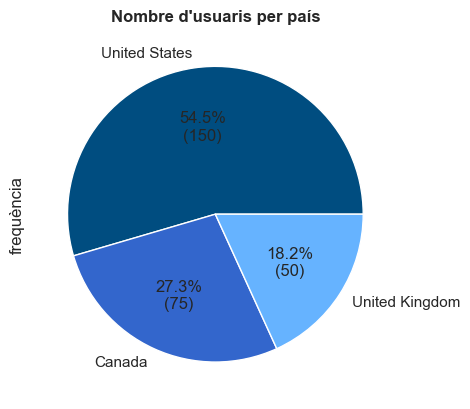

In [26]:
import matplotlib.pyplot as plt

#Faig servir una funció se series per comptar les vegades per país
#dataset=df["users"]["country"]

#Per simular l'objecte Py de Power BI, a partir d'aquí assignem dataset al DataFrame que conté les variables que passem al visualitzador Py
dataset=pd.DataFrame(df["users"]["country"])
#Converteixo la serie a dataframe doncs em va millor per pintar amb pandas
#dataset=pd.DataFrame(serie_count_x_country)

#Especifico una tonalitat de colors blaus per pintar el gràfic de sectors. De blau més fort a blau més clar
colors = ['#004d80','#3366cc','#66b3ff']

#funció per mostrar els valors i porcentatges del pie
def func(pct, allvalues):
    absolute = int(round(pct/100.*sum(allvalues)))
    return "{:.1f}%\n({:d})".format(pct, absolute)
# dataset["country"].value_counts() és una sèrie de dos paisos l'index els països i de valors la freqüència.
#directament pinta les freqüències com el tamany dels sectors del pie

ax=dataset["country"].value_counts().plot.pie(autopct=lambda pct: func(pct, dataset["country"].value_counts()),colors=colors)

ax.set_ylabel("frequència")
ax.set_title("Nombre d'usuaris per país",fontweight='bold')

#### **Exercici 4**

##### Una variable categòrica i una numèrica

Resolució: En aquest cas representerem les vendes per mes de les transaccions acceptades. Per tant confrontarem una sèrie numèrica amb
una sèrie de dates. Això ens obligarà una mica a treballar amb dates i agrupacions que serà interessant.

Converteixo la data timestamp a dates del tipus mes, per tal de poder agrupar per mes

C:\Users\Usuario\AppData\Local\Temp\ipykernel_33788\228678920.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["data_mes_any"]=pd.to_datetime(dataset["timestamp"]).apply(mes_any)


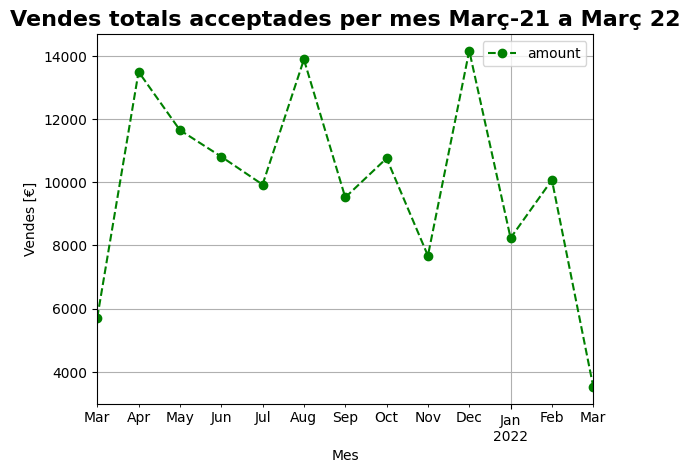

In [28]:
from datetime import date, time, datetime

def mes_any(data_timestamp):

    mes=data_timestamp.month
    any=data_timestamp.year
    dia=1
    return (pd.Timestamp(any,mes,dia))

#Per simular l'objecte Py de Power BI, a partir d'aquí assignem dataset al DataFrame que conté les variables que passem al visualitzador Py
dataset=df_transactions[["amount","timestamp","declined"]]
#Tinc que convertir pd.to_datetime, ja que no 
dataset["data_mes_any"]=pd.to_datetime(dataset["timestamp"]).apply(mes_any)

es_no_declinada=dataset["declined"]==0
trans_no_decl=dataset[es_no_declinada]

agrup_mes_any=trans_no_decl.groupby("data_mes_any")
Serie_vendes_x_mes_any=agrup_mes_any["amount"].sum()


plt.style.use("default")
#Ara per variar posem totes les propietats dins de la funció plot.
#Realment queda més net modificar les propietats per fora, amb mètodes que pengin de ax
ax=Serie_vendes_x_mes_any.plot(kind="line",
                               title="Vendes totals acceptades per mes Març-21 a Març 22",
                               use_index="True",
                               legend=True,
                               linestyle="dashed",
                               color="green",
                               marker="o",
                               grid=True,
                               ylabel="Vendes [€]",
                               xlabel="Mes")

ax.set_title("Vendes totals acceptades per mes Març-21 a Març 22", fontsize=16,fontweight='bold')
plt.show()

In [29]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           587 non-null    object        
 1   card_id      587 non-null    object        
 2   business_id  587 non-null    object        
 3   timestamp    587 non-null    datetime64[ns]
 4   amount       587 non-null    float64       
 5   declined     587 non-null    int64         
 6   product_ids  587 non-null    object        
 7   user_id      587 non-null    int64         
 8   lat          587 non-null    float64       
 9   longitude    587 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 46.0+ KB


#### **Exercici 5**

##### Dues variables categòriques

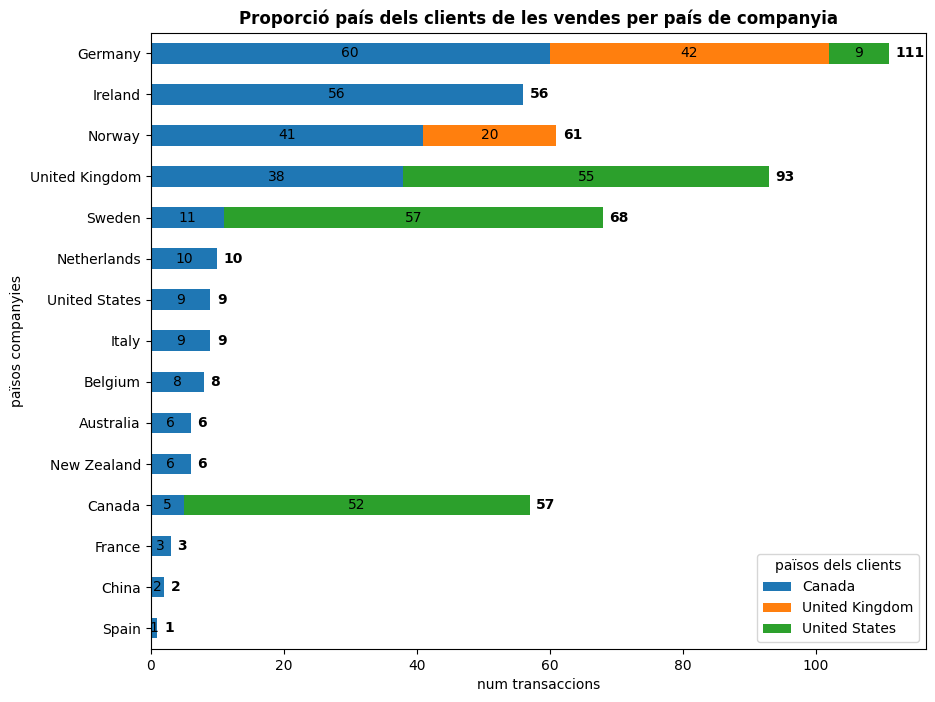

In [30]:
import matplotlib.pyplot as plt


#Si ho categoritzem no funciona a Power BI
#dataset["country_comp"]=dataset["country_comp"].astype("category")
#dataset["country_user"]=dataset["country_user"].astype("category")

#Per simular l'objecte Py de Power BI, a partir d'aquí assignem dataset al DataFrame que conté les variables que passem al visualitzador Py
dataset=df_id_trans_country_comp_country_user
is_not_declined=dataset["declined"]==0
dataset=dataset[is_not_declined]
agr_tr_no_decl_country_comp_country_user=dataset.groupby(["country_comp","country_user"])

Serie_country_comp_country_user=agr_tr_no_decl_country_comp_country_user["id_transac"].count()
df_country_comp_country_user=pd.DataFrame(Serie_country_comp_country_user)
df_country_comp_country_user=(df_country_comp_country_user.reset_index()).set_index("country_comp")

df_reset = df_country_comp_country_user.reset_index()
pivot_df = df_reset.pivot(index="country_comp", columns="country_user", values="id_transac")
pivot_df=pivot_df.fillna(0)
pivot_df["Total"]=pivot_df["Canada"]+pivot_df["United Kingdom"]+pivot_df["United States"]
pivot_df=pivot_df.sort_values("Canada",ascending=True)

ax=pivot_df[["Canada","United Kingdom","United States"]].plot.barh(stacked=True)

fig = ax.figure

# Ajustar las dimensiones de la figura
fig.set_size_inches(10, 8)


ax.set_title("Proporció país dels clients de les vendes per país de companyia",fontweight='bold')
ax.set_xlabel("num transaccions")
ax.set_ylabel("països companyies")
legend=ax.legend()
legend.set_title("països dels clients")

# Iterar sobre els contenidos i les barres per pintar cada valor de cada barra al centre de la barra.
for container in ax.containers:
    labels = []
    for bar in container:
        value = bar.get_width()
        if value == 0:
            labels.append('')  # No etiquetar barras con valor cero
        else:
            labels.append(f'{value:.0f}')
    ax.bar_label(container, labels=labels,label_type='center')

totals=pivot_df["Total"]

for i, total in enumerate(totals):
    ax.text(total + 1, i, str(int(total)), va='center', ha='left', fontweight='bold')  # Ajusta la posición según sea necesario

# Treure les quadrícules del fons
ax.grid(False)
plt.show()

#### **Exercici 6**

##### Tres variables

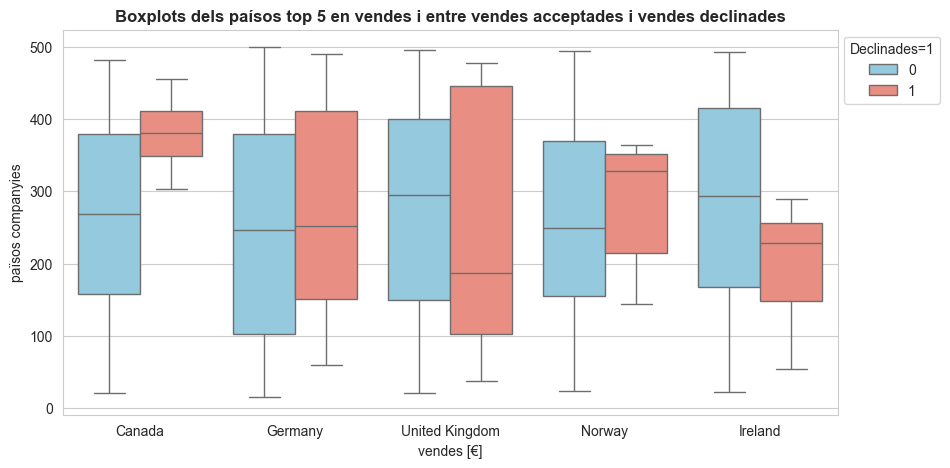

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

#Per simular l'objecte Py de Power BI, a partir d'aquí assignem dataset al DataFrame que conté les variables que passem al visualitzador Py
dataset=df_id_trans_country_comp_country_user
dataset.sort_values("amount",ascending=False)
son_paisos_top_5=dataset["country_comp"].isin(["Germany","United Kingdom","Sweeden","Ireland","Norway","Canada"])
df_trans_countryc_comp_top_5=dataset[son_paisos_top_5]

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

custom_palette = ['skyblue', 'salmon']

ax=sns.boxplot(x="country_comp",y="amount",data=df_trans_countryc_comp_top_5, hue="declined",palette=custom_palette)
ax.set_title("Boxplots dels paísos top 5 en vendes i entre vendes acceptades i vendes declinades",fontweight='bold')

#Per tal que no apareixi la etiqueta country a l'eix x
ax.set_xlabel("vendes [€]")
ax.set_ylabel("països companyies")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Declinades=1")
plt.legend(title='Declinades=1', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

#### **Exercici 7** 

##### Graficar un pairplot

Graficarem un pairplot a partir de totes les variables numèriques que tenim a la taula de transaccions

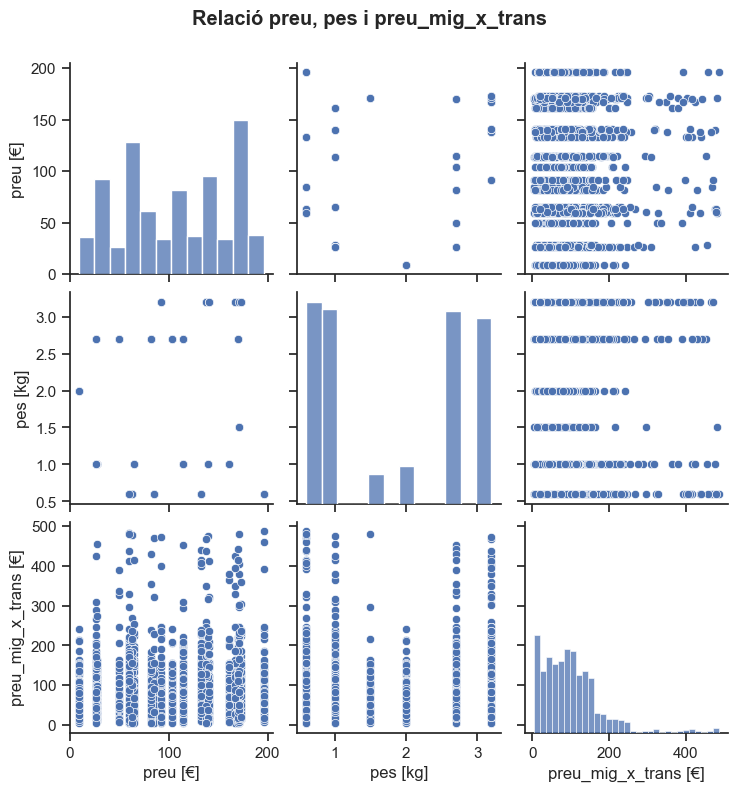

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

#Per simular l'objecte Py de Power BI, a partir d'aquí assignem dataset al DataFrame que conté les variables que passem al visualitzador Py
dataset=df_preu_pes_amount_lat_long_x_trans

#La invocación más simple utiliza scatterplot()para cada emparellament de variables i histplot()pels gràfics marginals al llarg de la diagonal:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)              
plot=sns.pairplot(data=dataset,
            vars=["preu","pes","preu_mig_x_trans"])
 
plot.figure.suptitle("Relació preu, pes i preu_mig_x_trans",y=1.05,fontweight='bold')
plot.figure

 
plot.axes[0,0].set(ylabel="preu [€]")
plot.axes[1,0].set(ylabel="pes [kg]")
plot.axes[2,0].set(ylabel="preu_mig_x_trans [€]")
   
plot.axes[2,0].set(xlabel="preu [€]")
plot.axes[2,1].set(xlabel="pes [kg]")
plot.axes[2,2].set(xlabel="preu_mig_x_trans [€]") 
                                                     
plt.show()



##  Nivell 2

#### **Exercici 1**

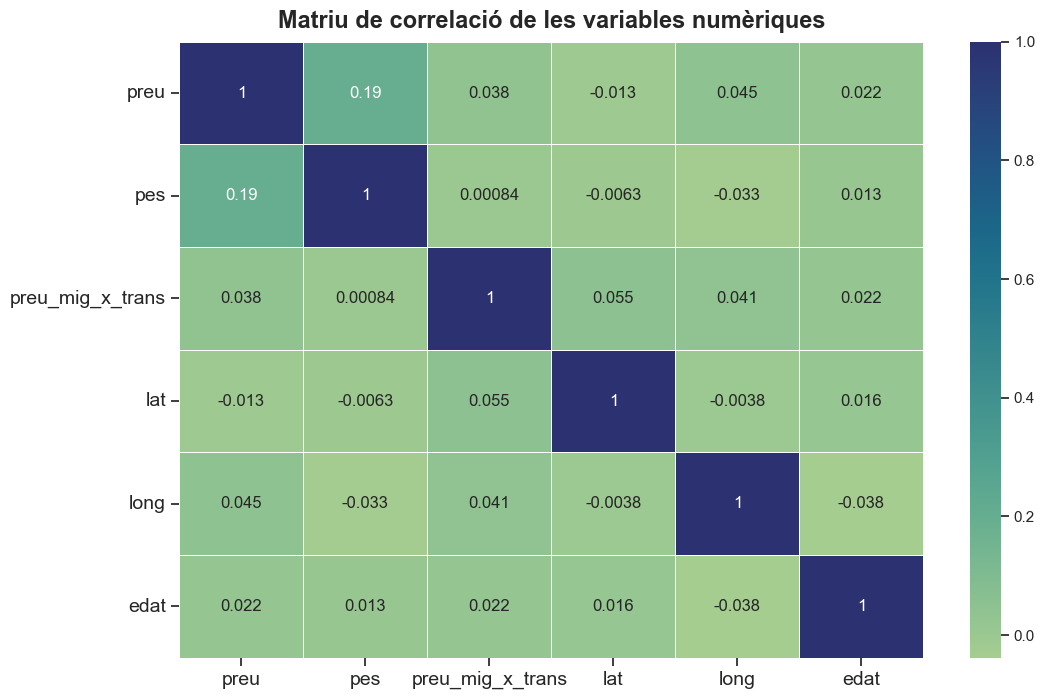

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

#Per simular l'objecte Py de Power BI, a partir d'aquí assignem dataset al DataFrame que conté les variables que passem al visualitzador Py
dataset=df_preu_pes_amount_lat_long_x_trans
columnes=["preu","pes","preu_mig_x_trans","lat","long","edat"]
df_matriu_correlacions=dataset[columnes].corr()
plt.figure(figsize=(12, 8))
grid=sns.heatmap(df_matriu_correlacions,cmap="crest",annot=True,linewidth=.5)
grid.axes.set_title("Matriu de correlació de les variables numèriques",pad=10,fontsize=17,fontweight='bold')
plt.xticks(fontsize=14, rotation=0)  # Tamaño y rotación de las etiquetas del eje x
plt.yticks(fontsize=14, rotation=0)

plt.show()

#### **Exercici 2**

##### Implementa un joinplot

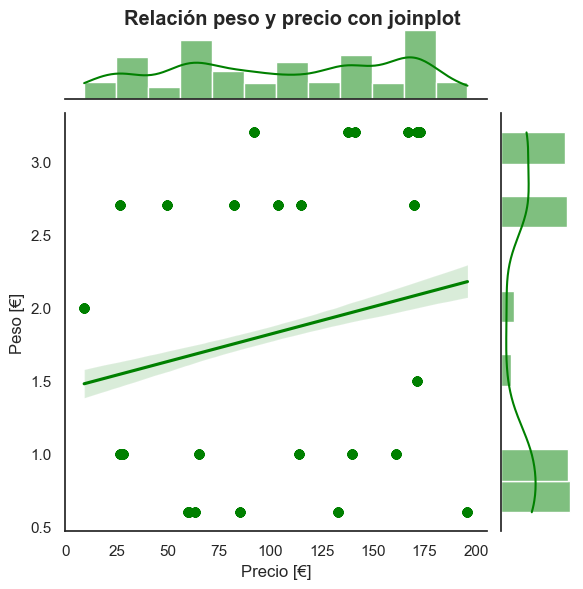

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("white")
sns.set_context("notebook")

#Per simular l'objecte Py de Power BI, a partir d'aquí assignem dataset al DataFrame que conté les variables que passem al visualitzador Py
dataset= df_preu_pes_amount_lat_long_x_trans  

#Per defecte si no escollim res ens triaria kind="reg", però ho posem perquè és el que volíem visualitzar
grid=sns.jointplot(x="preu",y="pes",data=dataset,kind="reg",color="green")

grid.set_axis_labels("Precio [€]","Peso [kg]")
grid.figure.suptitle("Relación peso y precio con joinplot",fontweight='bold')
grid.fig.subplots_adjust(top=0.95)
plt.show()

## Nivell 3

####  **Exercici 1**

Implementa un violinplot combinat amb un altre tipus de gràfic

C:\Users\Usuario\AppData\Local\Temp\ipykernel_33788\2671147620.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.violinplot(x="country",y="amount",data=dataset, palette=custom_palette)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_33788\2671147620.py:8: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  ax=sns.violinplot(x="country",y="amount",data=dataset, palette=custom_palette)


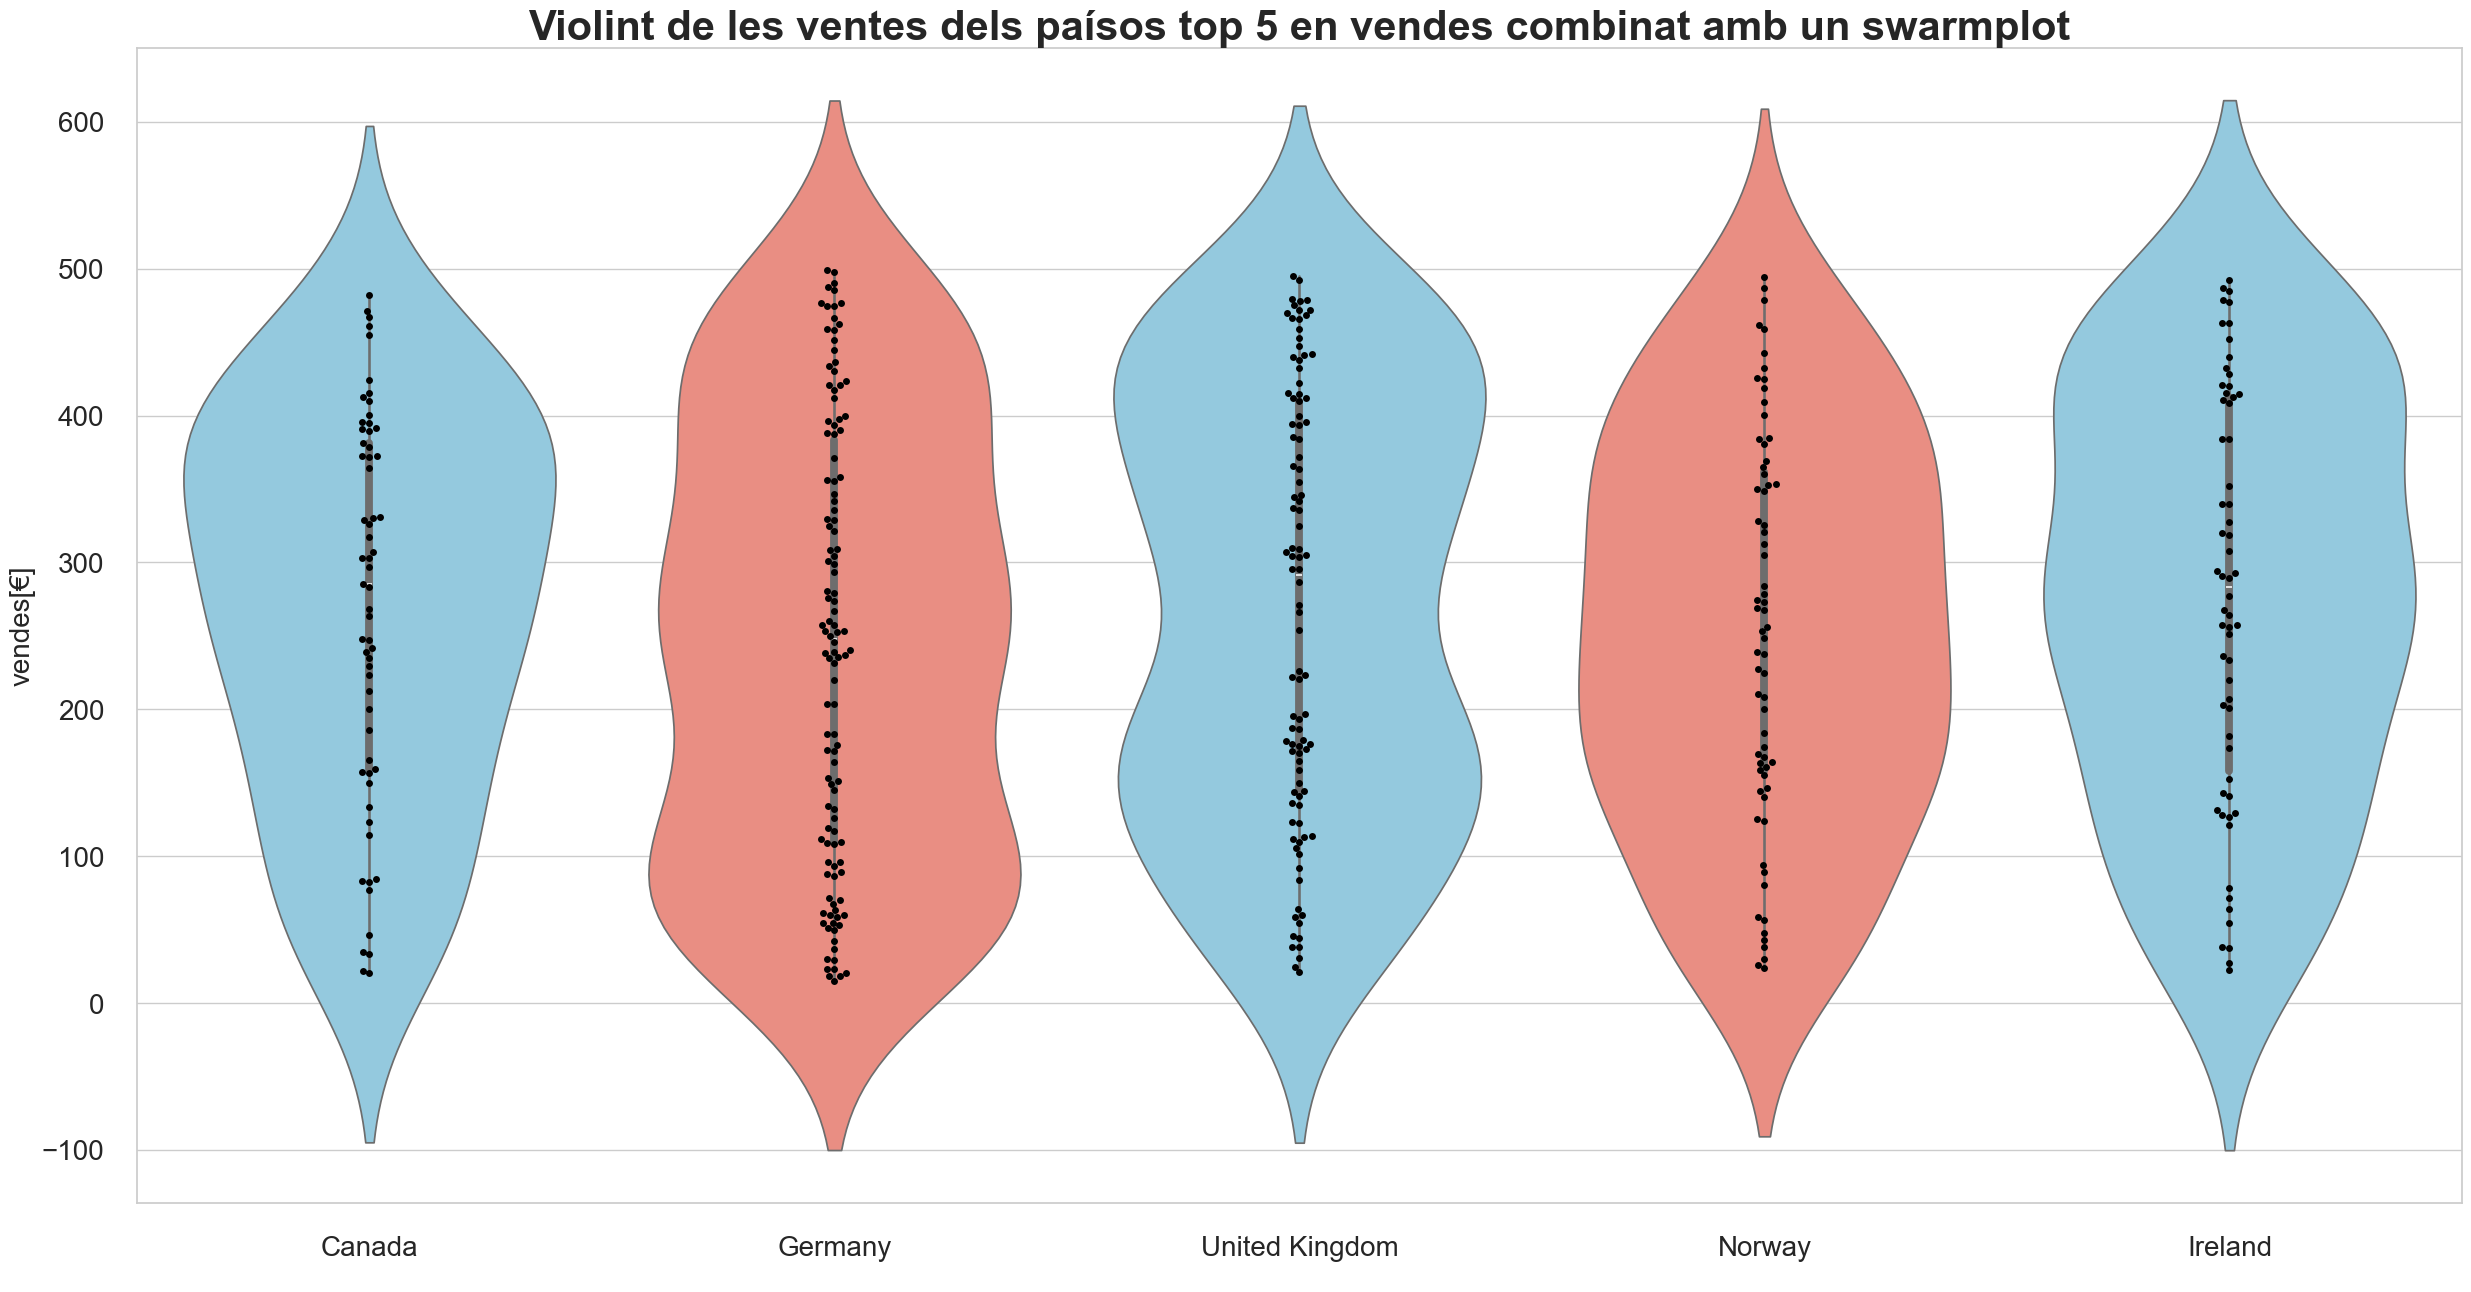

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns


#Per simular l'objecte Py de Power BI, a partir d'aquí assignem dataset al DataFrame que conté les variables que passem a l'objecte Py
dataset=df_trans_merge_company_top_5

plt.figure(figsize=(30, 15))
sns.set_style("whitegrid")

custom_palette = ['skyblue', 'salmon']

ax=sns.violinplot(x="country",y="amount",data=dataset, palette=custom_palette)
ax=sns.swarmplot(x="country", y="amount", data=dataset,color='black',size=5);
ax.set_title("Violint de les ventes dels paísos top 5 en vendes combinat amb un swarmplot",fontsize=30,fontweight='bold')
#ax.set_xticklabels(["venda acceptada","venda declinada"])
#Per tal que no apareixi la etiqueta country a l'eix x
ax.set_xlabel("     ")
ax.set_ylabel("vendes[€]",fontsize=20)

# Aumentar el tamaño de los ejes x e y
ax.tick_params(axis='x', labelsize=20)  # Tamaño de la fuente de las etiquetas del eje x
ax.tick_params(axis='y', labelsize=20)  # Tamaño de la fuente de las etiquetas del eje y
ax.tick_params(axis='both', which='major', size=20)  # Tamaño de los números en los ejes x e y

plt.show()

#### **Exercici 2**

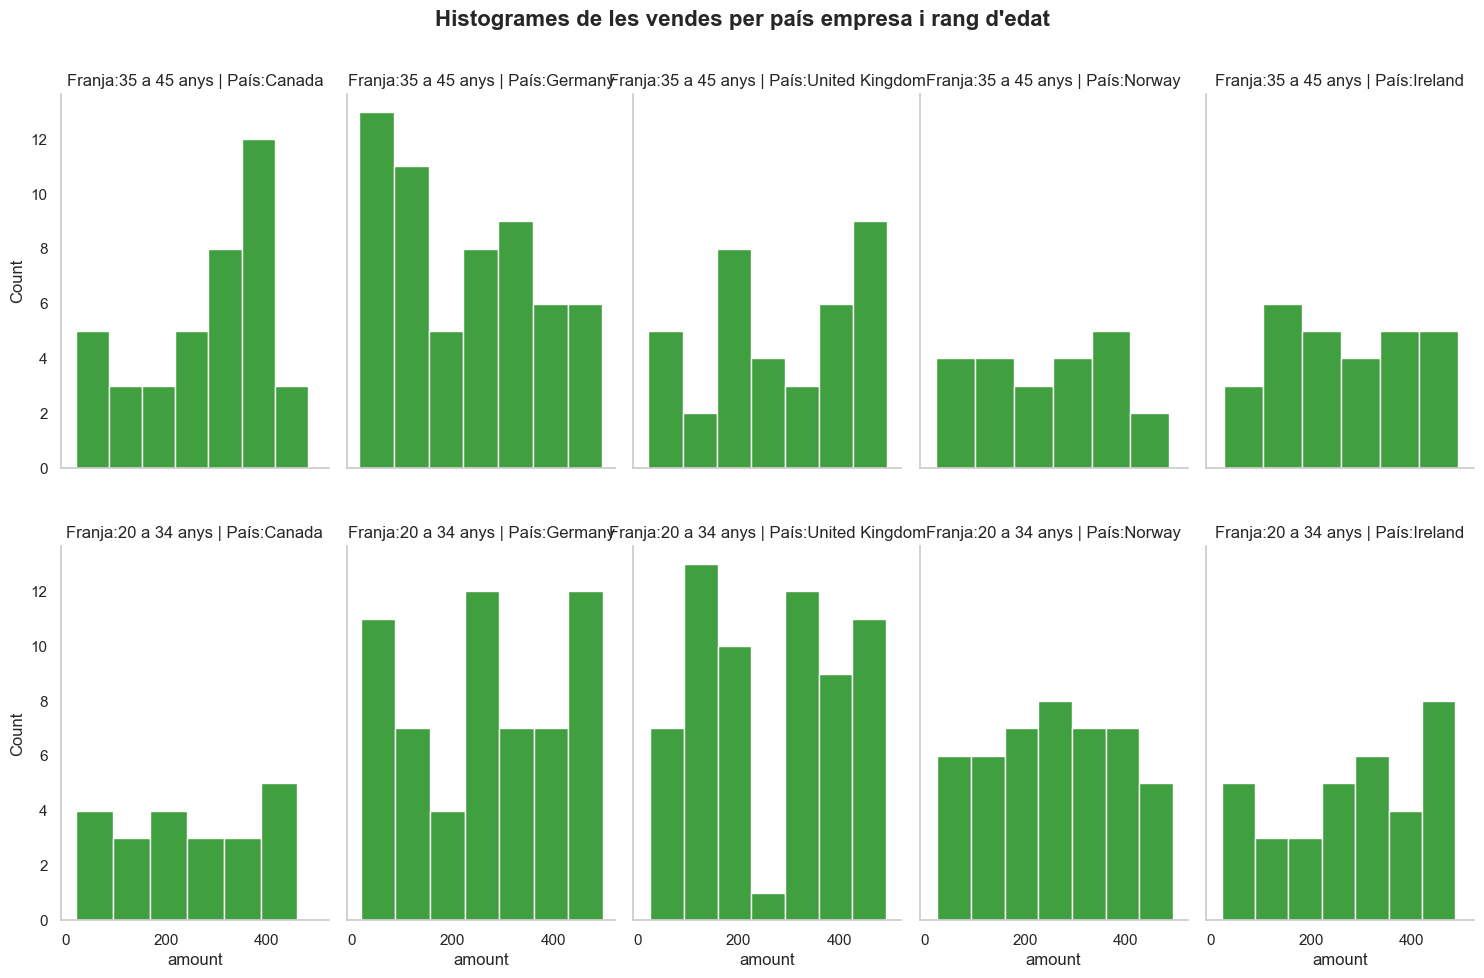

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

#Per simular l'objecte Py de Power BI, a partir d'aquí assignem dataset al DataFrame que conté les variables que passem al visualitzador Py
dataset=df_trans_merge_company_top_5_user

g=sns.FacetGrid(dataset, row="rg_edat",  col="country_x",palette="crest")
g.map_dataframe(sns.histplot, x="amount",color="green")

# Personalizar los títulos de los subgráficos
g.set_titles(row_template='Franja:{row_name}', col_template='País:{col_name}')

# Quitar el grid de los gráficos
#g.set(grid=False)

g.fig.set_size_inches(15, 10)
g.fig.suptitle("Histogrames de les vendes per país empresa i rang d'edat", fontsize=16, fontweight='bold', y=1.02)
# Ajustar las dimensiones de la figura
#fig.set_size_inches(70, 70)
#fig.suptitle('Histogramas de las vendas por top 5 países empresa i rangos edad', fontsize=20, fontweight='bold', y=0.8)

#Desactivar el grid per cada un dels subgràfics
for ax in g.axes.flatten():
    ax.grid(False)

plt.show()